# try and recreate a species stack given a galaxy

In [1]:
%matplotlib inline
from pyigm.cgm import cgmsurvey
from linetools.spectra.io import readspec
import linetools
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import scipy.stats as stats
%config InlineBackend.figure_format = "retina"

from linetools.lists.linelist import LineList
%load_ext autoreload
%autoreload 2

def get_qsoname_from_string(filename):
    """ Find the QSO name (JXXXX+XXXX) in a string, usually the file path.

    Args:
        filename (str): path with qso file

    Returns:
        qsoname (str): qso name (JXXXX+XXXX)


    """
    #if "J0226+001" not in filename:
    #    qso_name = filename[filename.find('J'):filename.find('J') + 10]
    #else:
    #    qso_name = filename[filename.find('J'):filename.find('J') + 9]
    qso_name = filename[filename.find('J'):filename.find('J') + 10]

    return qso_name


In [2]:
def attach_spectra(cgm_survey, data_path='../data/spectra/'):
    """ Give each component and line a QSO spectrum to plot. 
    
    Arguments:
        cgm_survey {pyigm.cgm.cgmsurvey.CGMAbsSurvey} -- The object containing all of the CGM Survey data.
    
    Keyword Arguments:
        data_path {str} -- Where to look for the spectra (default: {'../data/spectra/'})
    """
    for name in cgm_survey._data['Name']:
        # get the base name from the longer form associated with cgm abs systems
        qso_name = get_qsoname_from_string(name)
        # point to the correct path
        specfile = data_path+qso_name+'_nbin3_norm.fits'
        # crate an Xspec1D object from the spec
        spec = readspec(specfile)
        # attach the spec object to each absorption line in each component for each galaxy
        cgm_abs_sys = cgm_survey.get_cgmsys(name)
        for comp in cgm_abs_sys._components:
            for absline in comp._abslines:
                absline.analy['spec'] = spec

In [3]:
survey_file = '../data/cgmsquared_cgmsurvey_aodm_v4.json'
cgm_survey = cgmsurvey.CGMAbsSurvey.from_json(survey_file, chk_z=False, verbose=False, build_sys=True)
attach_spectra(cgm_survey, data_path='../data/spectra/')


read_sets: Using set file -- 
  /Users/mwilde/python/linetools/linetools/lists/sets/llist_v1.2.ascii
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


In [4]:
data_path='../data/spectra/'
cgm_name = 'J1233-0031_247_12'
cgm_abs_sys = cgm_survey.get_cgmsys(cgm_name)
# get the base name from the longer form associated with cgm abs systems
qso_name = get_qsoname_from_string(cgm_name)
# point to the correct path
specfile = data_path+qso_name+'_nbin3_norm.fits'
# crate an Xspec1D object from the spec
spec = readspec(specfile)

ilist = LineList('ISM')
f = spec.flux
w = spec.wavelength
sig = spec.sig

if spec.co_is_set:
    co = spec.co
else:
    co = 1.
    
norm_flux = f/co
norm_sig = sig/co
z_gal = cgm_abs_sys.z

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


In [5]:
to_plot = 'OVI'

In [6]:
wlims = (spec.wvmin/(1+z_gal), spec.wvmax/(1+z_gal))
strong = ilist.strongest_transitions(to_plot, wlims, n_max=5)
strong_hi = ilist.strongest_transitions('HI', wlims, n_max=1)
if strong is None: #  No lines covered in the spectra
    print('No lines for {} are covered by the spectra'
                  'provided.'.format(to_plot))

# number of lines    
nlines = len(strong['name'])

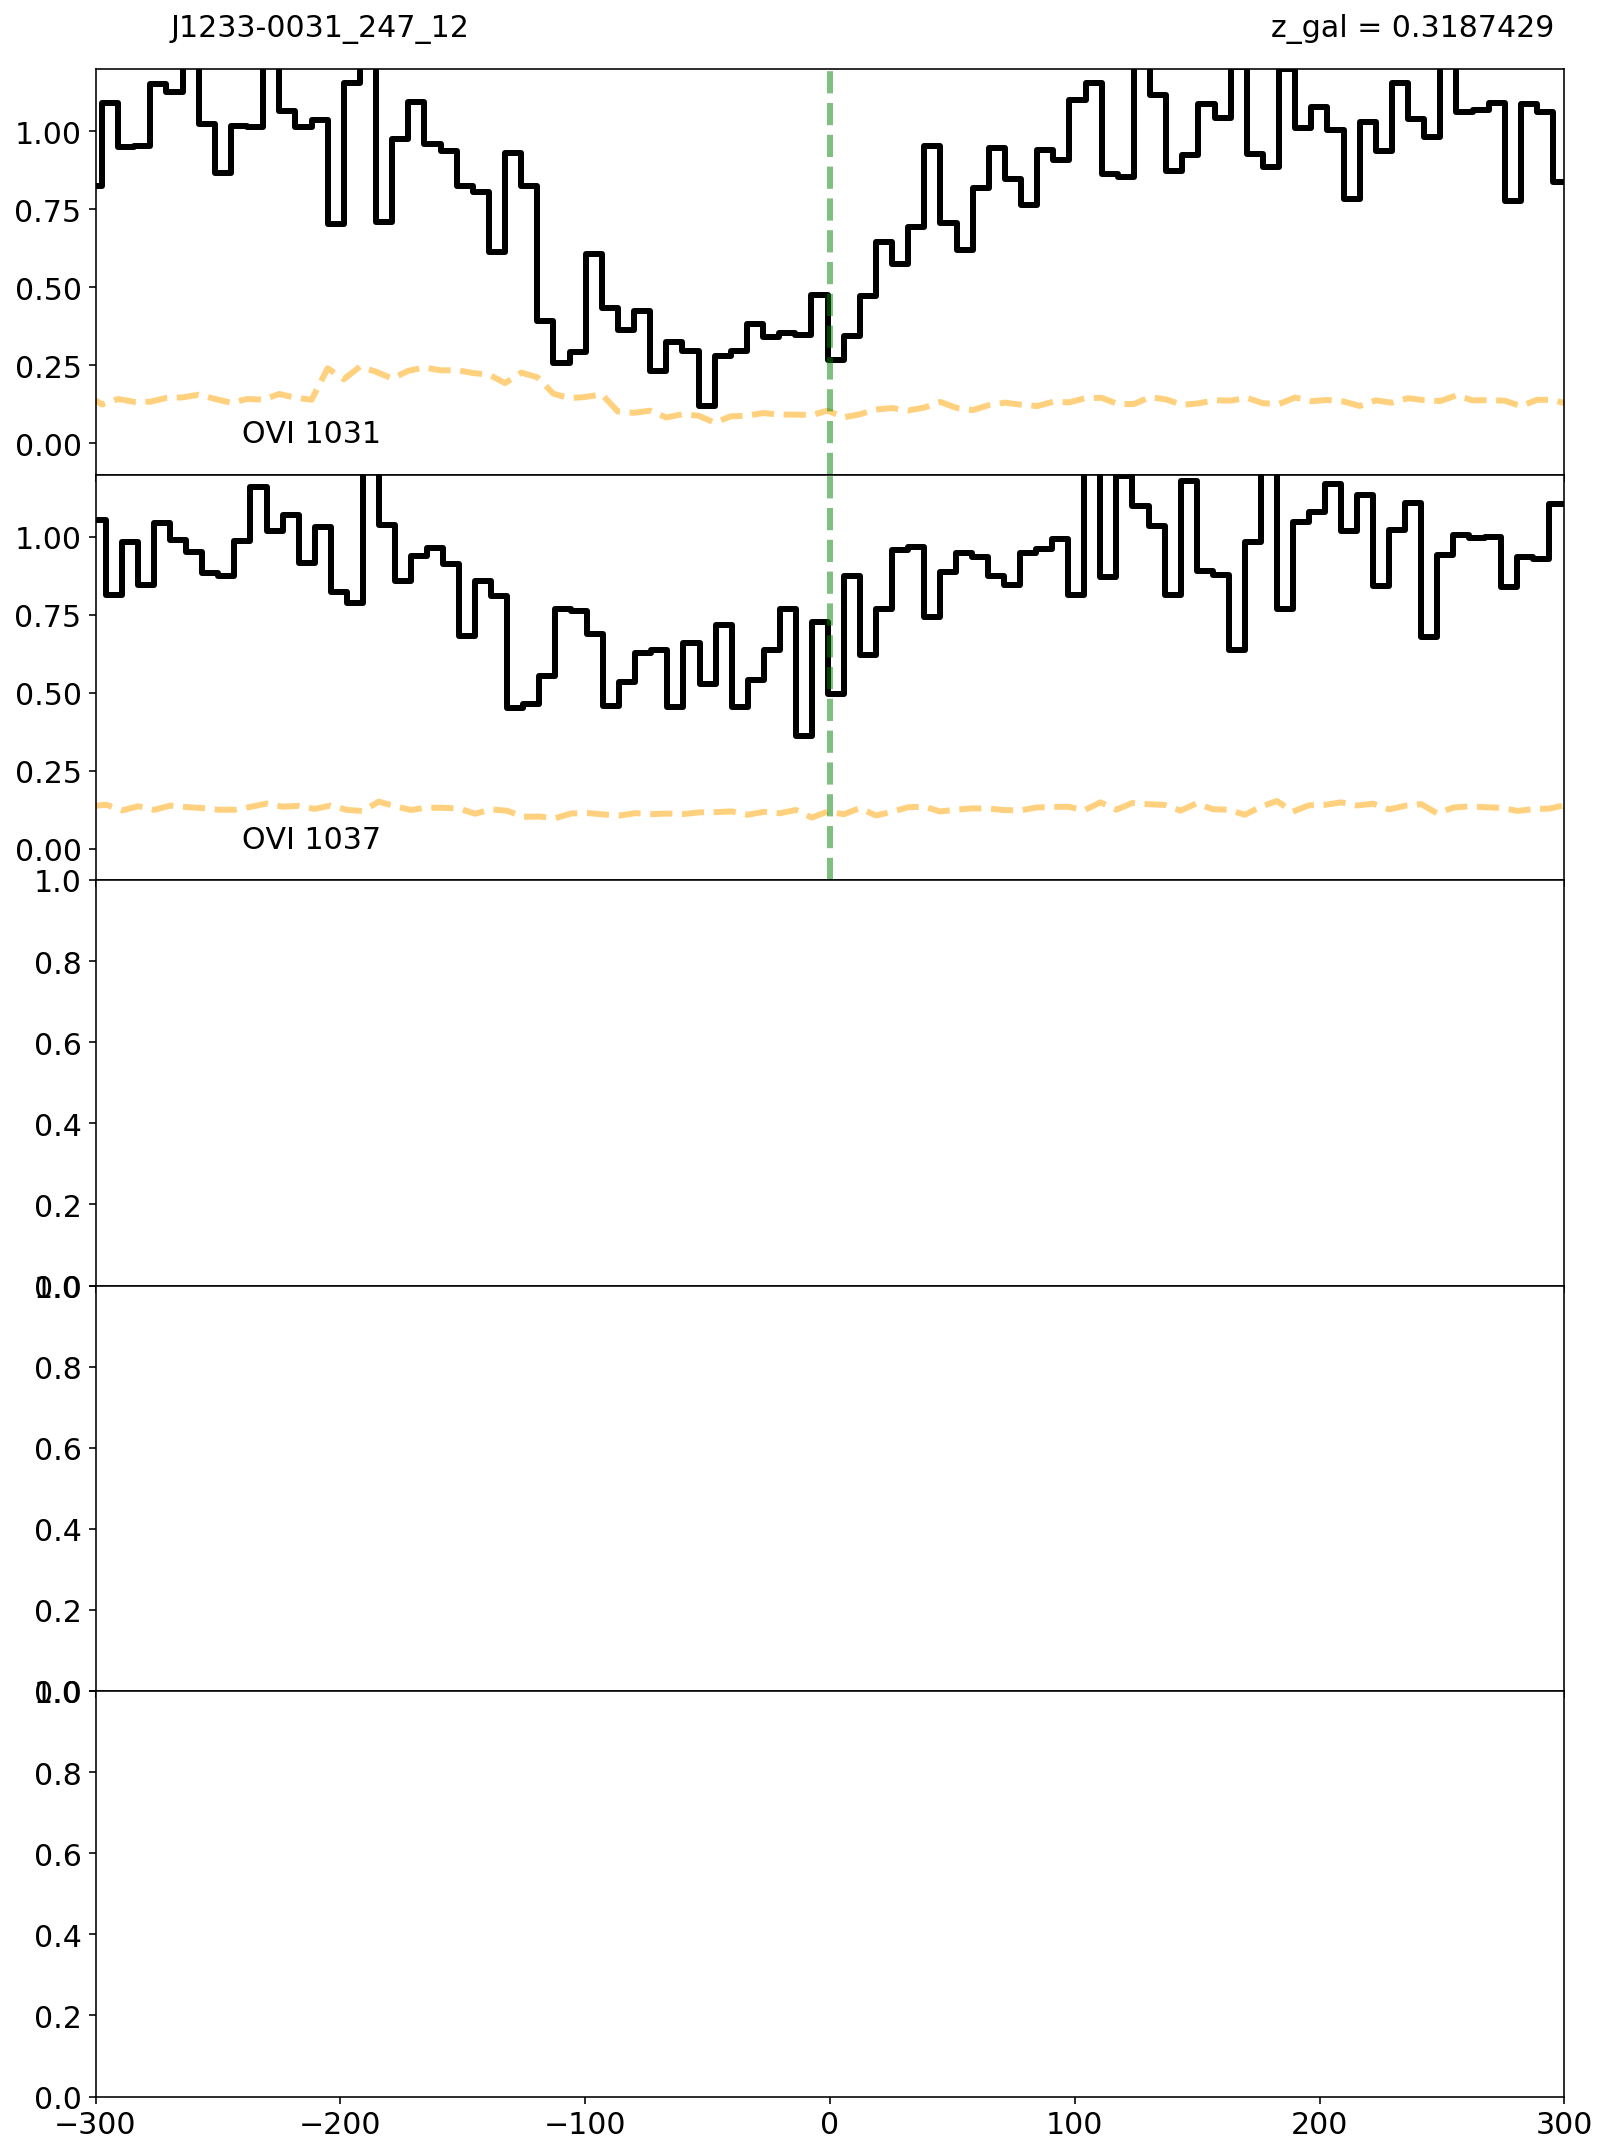

In [12]:
plt.rcParams['font.size'] = 15.
fig, axes = plt.subplots(nrows=5, figsize=(12,16), sharex=True)
vlim=[-300., 300]*u.km/u.s
ymnx=(-0.1,1.2)
if not isinstance(strong, dict):    
    # plot the rest
    for ax, iline in zip(axes, strong):
        
        wrest = iline['wrest']
        name = iline['name']
        velo = spec.relative_vel((1+z_gal)*wrest*u.AA)

        # plot the data
        ax.step(velo, norm_flux, lw=3, color='k')
        ax.plot(velo, norm_sig, '--', lw=3, color='orange', alpha=0.5)
        ax.plot([0]*2, ymnx, 'g--', lw=3, alpha=0.5)#, 'g--')
        # ax.plot(velo, 1-12*stats.norm.pdf(velo, 0, 60))


        # plot cleanup stuff
        ax.set_xlim(vlim.value)
        ax.set_ylim(ymnx)
        ax.text(0.1, 0.1, name, transform=ax.transAxes, ha='left', va='center')
else:
    ax = axes[0]
    iline = strong

    wrest = iline['wrest']
    name = iline['name']
    velo = spec.relative_vel((1+z_gal)*wrest)

    # plot the data
    ax.plot(velo, norm_flux, lw=3, color='k')
    ax.plot(velo, norm_sig, '--', lw=3, color='orange', alpha=0.5)
    ax.plot([0]*2, ymnx, 'g--', lw=3, alpha=0.5)#, 'g--')
    ax.plot(velo, 1-stats.norm.pdf(velo, 0, 60))

    # plot cleanup stuff
    ax.set_xlim(vlim.value)
    ax.set_ylim(ymnx)
    ax.text(0.1, 0.1, name, transform=ax.transAxes, ha='left', va='center')
# plt.tight_layout(pad=0., h_pad=0., w_pad=0.)
zstring = f"z_gal = {z_gal}"
axes[0].text(0.8, 1.1, zstring, transform=axes[0].transAxes, ha='left', va='center')
axes[0].text(0.051, 1.1, cgm_name, transform=axes[0].transAxes, ha='left', va='center')
fig.subplots_adjust(bottom=0.,left=0.1,right=0.95,hspace=0.,wspace=0.35)

In [ ]:
strong

# Try and put strongest HI in the first plot no matter the species

In [ ]:
plt.rcParams['font.size'] = 15.
fig, axes = plt.subplots(nrows=5, figsize=(12,16), sharex=True)
vlim=[-300., 300]*u.km/u.s
if not isinstance(strong, dict):
    wrest = strong_hi['wrest']
    name = strong_hi['name']
    velo = spec.relative_vel((1+z_gal)*wrest*u.AA)
    # plot the data
    axes[0].plot(velo, norm_flux, lw=3, color='k')
    axes[0].plot(velo, norm_sig, '--', lw=3, color='orange', alpha=0.5)
    axes[0].plot([0]*2, ymnx, 'g--', lw=3, alpha=0.5)#, 'g--')
    axes[0].plot(velo, 1-stats.norm.pdf(velo, 0, 60))
    
    # plot the rest
    for ax, iline in zip(axes[1:], strong):
        
        wrest = iline['wrest']
        name = iline['name']
        velo = spec.relative_vel((1+z_gal)*wrest*u.AA)

        # plot the data
        ax.plot(velo, norm_flux, lw=3, color='k')
        ax.plot(velo, norm_sig, '--', lw=3, color='orange', alpha=0.5)
        ax.plot([0]*2, ymnx, 'g--', lw=3, alpha=0.5)#, 'g--')
        ax.plot(velo, 1-stats.norm.pdf(velo, 0, 60))


        # plot cleanup stuff
        ax.set_xlim(vlim.value)
        ax.set_ylim(ymnx)
        ax.text(0.1, 0.1, name, transform=ax.transAxes, ha='left', va='center')
else:
    ax = axes[1]
    iline = strong

    wrest = iline['wrest']
    name = iline['name']
    velo = spec.relative_vel((1+z_gal)*wrest)

    # plot the data
    ax.plot(velo, norm_flux, lw=3, color='k')
    ax.plot(velo, norm_sig, '--', lw=3, color='orange', alpha=0.5)
    ax.plot([0]*2, ymnx, 'g--', lw=3, alpha=0.5)#, 'g--')
    ax.plot(velo, 1-stats.norm.pdf(velo, 0, 60))

    # plot cleanup stuff
    ax.set_xlim(vlim.value)
    ax.set_ylim(ymnx)
    ax.text(0.1, 0.1, name, transform=ax.transAxes, ha='left', va='center')
# plt.tight_layout(pad=0., h_pad=0., w_pad=0.)
zstring = f"z_gal = {z_gal}"
axes[0].text(0.8, 1.1, zstring, transform=ax.transAxes, ha='left', va='center')
axes[0].text(0.051, 1.1, cgm_name, transform=ax.transAxes, ha='left', va='center')
fig.subplots_adjust(bottom=0.,left=0.1,right=0.95,hspace=0.,wspace=0.35)

In [ ]:
lav.voigt_from_abslines(spec.wavelength, cgm_abs_sys._components[0]._abslines)